# Internals

In [1]:
import polars as pl
pl.__version__

'1.20.0'

## Polars' Architecture

## Arrow

## Multithreaded Computations and SIMD Operations

## The String Data Type in Memory

## ChunkedArrays in Series

## Query Optimization

### LazyFrame Scan-Level Optimizations

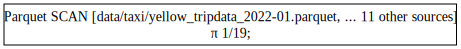

In [2]:
taxis = pl.scan_parquet("data/taxi/yellow_tripdata_*.parquet")
taxis.select(pl.col("trip_distance")).show_graph()

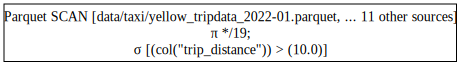

In [3]:
taxis.filter(pl.col("trip_distance") > 10).show_graph()

In [4]:
taxis.head(2).collect()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i64,datetime[ns],datetime[ns],f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,"""N""",142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,"""N""",236,42,1,8.0,0.5,0.5,4.0,0.0,0.3,13.3,0.0,0.0


### Other Optimizations

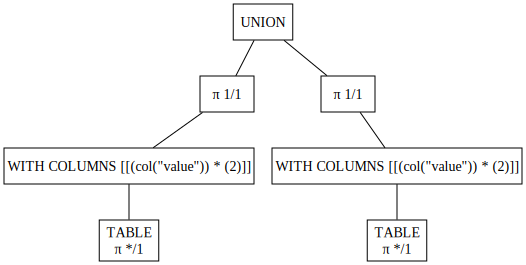

In [5]:
values = pl.LazyFrame({"value": [10, 20, 30, 40, 50, 60]})

common_subplan = values.with_columns(pl.col("value") * 2)

branch1 = common_subplan.select(value2=pl.col("value") * 4)
branch2 = common_subplan.select(value3=pl.col("value") * 2)

combined = pl.concat([branch1, branch2])

combined.show_graph(optimized=False)

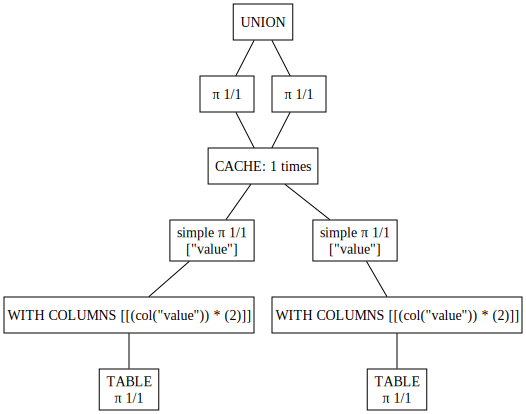

In [6]:
combined.show_graph()

In [7]:
bmi = pl.LazyFrame(
    {"weight_kg": [70, 80, 60, 90], "length_cm": [175, 180, 160, 190]}
)

In [8]:
bmi = (
    bmi.with_columns(weight_per_cm=pl.col("weight_kg") / pl.col("length_cm"))
    .with_columns(weight_kg_average=pl.lit(0))
    .with_columns(length_m=pl.col("length_cm") / 100)
    .with_columns(weight_kg_average=pl.col("weight_kg").mean())
)

In [9]:
bmi = bmi.with_columns(
    weight_per_cm=pl.col("weight_kg") / pl.col("length_cm"),
    weight_kg_average=pl.col("weight_kg").mean(),
    length_m=pl.col("length_cm") / 100,
)

## Checking Your Expressions

### meta Namespace Overview

### meta Namespace Examples

In [10]:
expr1 = pl.col("name")
expr2 = pl.lit("constant")

print(f"Is {expr1} a column: {expr1.meta.is_column()}")
print(f"Is {expr2} a column: {expr2.meta.is_column()}")

Is col("name") a column: True
Is String(constant) a column: False


In [11]:
print(f"Is {expr1} a literal: {expr1.meta.is_literal()}")
print(f"Is {expr2} a literal: {expr2.meta.is_literal()}")

Is col("name") a literal: False
Is String(constant) a literal: True


In [12]:
expr1 = pl.col("age") * 2
expr2 = pl.col("name").alias("username")

# Get output names
print(f"{expr1} output name: {expr1.meta.output_name()}")
print(f"{expr2} output name: {expr2.meta.output_name()}")

[(col("age")) * (dyn int: 2)] output name: age
col("name").alias("username") output name: username


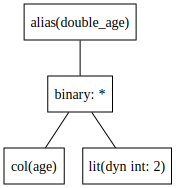

In [13]:
expr = (pl.col("age") * 2).alias("double_age")

expr.meta.show_graph()

In [14]:
expr = pl.col("original_name").alias("new_name")

original_expr = expr.meta.undo_aliases()

original_expr.meta.output_name()

'original_name'

In [15]:
expr = pl.col("origin").alias("destination")

expr.meta.root_names()

['origin']

## Profiling Polars

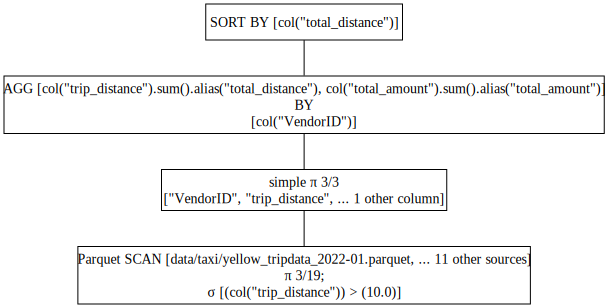

In [16]:
long_distance_taxis_per_vendor_sorted = (
    pl.scan_parquet("data/taxi/yellow_tripdata_*.parquet")
    .filter(pl.col("trip_distance") > 10)
    .select(pl.col("VendorID"), pl.col("trip_distance"), pl.col("total_amount"))
    .group_by("VendorID")
    .agg(
        total_distance=pl.col("trip_distance").sum(),
        total_amount=pl.col("total_amount").sum(),
    )
    .sort("total_distance", descending=True)
)

long_distance_taxis_per_vendor_sorted.show_graph()

In [17]:
result, profiling_info = long_distance_taxis_per_vendor_sorted.profile()

In [ ]:
result

In [ ]:
profiling_info

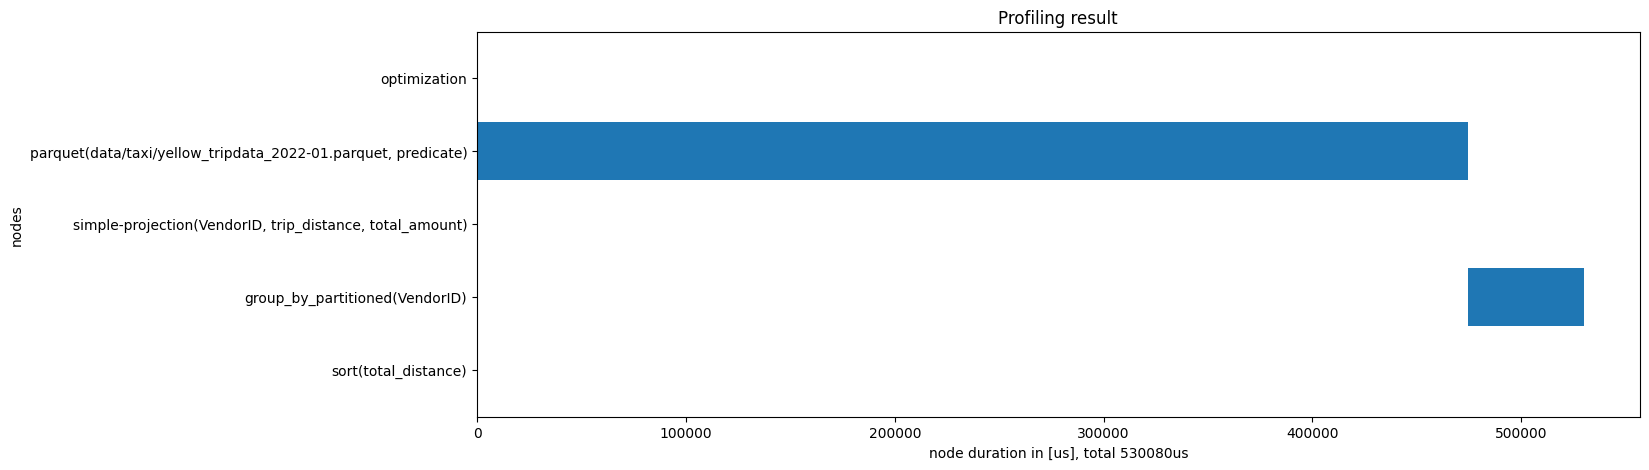

(shape: (4, 3)
 ┌──────────┬────────────────┬──────────────┐
 │ VendorID ┆ total_distance ┆ total_amount │
 │ ---      ┆ ---            ┆ ---          │
 │ i64      ┆ f64            ┆ f64          │
 ╞══════════╪════════════════╪══════════════╡
 │ 2        ┆ 1.3752e8       ┆ 1.6152e8     │
 │ 1        ┆ 1.3095e7       ┆ 5.2274e7     │
 │ 6        ┆ 347579.41      ┆ 1.3881e6     │
 │ 5        ┆ 1956.44        ┆ 8702.21      │
 └──────────┴────────────────┴──────────────┘,
 shape: (5, 3)
 ┌─────────────────────────────────┬────────┬────────┐
 │ node                            ┆ start  ┆ end    │
 │ ---                             ┆ ---    ┆ ---    │
 │ str                             ┆ u64    ┆ u64    │
 ╞═════════════════════════════════╪════════╪════════╡
 │ optimization                    ┆ 0      ┆ 10     │
 │ parquet(data/taxi/yellow_tripd… ┆ 10     ┆ 474465 │
 │ simple-projection(VendorID, tr… ┆ 474467 ┆ 474473 │
 │ group_by_partitioned(VendorID)  ┆ 474476 ┆ 529928 │
 │ sort(total_

In [18]:
long_distance_taxis_per_vendor_sorted.profile(show_plot=True, figsize=(15, 5))

## Tests in Polars

### Comparing DataFrames and Series

In [19]:
from polars.testing import (
    assert_series_equal,
    assert_frame_equal,
    assert_series_not_equal,
    assert_frame_not_equal,
)

In [20]:
floats = pl.DataFrame({"a": [1.0, 2.0, 3.0, 4.0]})

different_floats = pl.DataFrame({"a": [1.001, 2.0, 3.0, 4.0]})

In [ ]:
# This raises an AssertionError:
# assert_frame_equal(floats, different_floats)

In [21]:
assert_frame_equal(floats, different_floats, rtol=0.01)
print("The DataFrames are equal.")

The DataFrames are equal.


In [22]:
result = pl.DataFrame({"a": [1, 3], "b": [2, 4]}).cast(
    pl.Schema({"a": pl.Int8, "b": pl.Int8})
)

expected = pl.from_repr(
    """
┌─────┬─────┐
│ a   ┆ b   │
│ --- ┆ --- │
│ i8  ┆ i8  │
╞═════╪═════╡
│ 1   ┆ 2   │
│ 3   ┆ 4   │
└─────┴─────┘
    """
)

assert_frame_equal(result, expected)
print("DataFrames are equal")

DataFrames are equal


## Common Antipatterns

### Using Brackets for Column Selection

### Misusing Collect

In [ ]:
%%time
taxis = pl.scan_parquet("data/taxi/yellow_tripdata_*.parquet")
vendor0 = taxis.filter(pl.col("VendorID") == 0).collect()
vendor1 = taxis.filter(pl.col("VendorID") == 1).collect()

In [ ]:
%%time
taxis = pl.scan_parquet("data/taxi/yellow_tripdata_*.parquet")
vendors = taxis.filter(pl.col("VendorID").is_in([0, 1])).collect()
vendor0 = vendors.filter(pl.col("VendorID") == 0)
vendor1 = vendors.filter(pl.col("VendorID") == 1)

### Using Python Code in your Polars Queries